In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
kdd = pd.read_csv('/home/gsoykan20/Desktop/inzva/week2/homework-20210808T093349Z-001/homework/kdd.csv')
kdd = kdd.iloc[:,1:43]
kdd = kdd.drop(['Protocol Type', 'Service', 'Flag'], axis = 1)

kdd_train = kdd.iloc[0:102563, :]
kdd_test = kdd.iloc[102563:183737, :]

In [3]:
kdd_train_probe = kdd_train[(kdd_train.Type_Groups == 'Normal') | (kdd_train.Type_Groups == 'Probe')]
kdd_test_probe = kdd_test[(kdd_test.Type_Groups == 'Normal') | (kdd_test.Type_Groups == 'Probe')]

# kdd_train_probe['Type_Groups'] = np.where(kdd_train_probe['Type_Groups'] == 'Normal', 0, 1)
# kdd_test_probe['Type_Groups'] = np.where(kdd_test_probe['Type_Groups'] == 'Normal', 0, 1)

kdd_train_probe['Type_Groups'] = np.where(kdd_train_probe['Type_Groups'] == 'Normal', 1, -1)
kdd_test_probe['Type_Groups'] = np.where(kdd_test_probe['Type_Groups'] == 'Normal', 1, -1)

<ipython-input-3-c34883aceaa3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kdd_train_probe['Type_Groups'] = np.where(kdd_train_probe['Type_Groups'] == 'Normal', 1, -1)
<ipython-input-3-c34883aceaa3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kdd_test_probe['Type_Groups'] = np.where(kdd_test_probe['Type_Groups'] == 'Normal', 1, -1)


In [4]:
kdd_train_probe.Type_Groups.value_counts()

 1    97278
-1     4107
Name: Type_Groups, dtype: int64

In [5]:
kdd_valid_probe = kdd_test_probe.iloc[14000:34000,:]
kdd_test_v2_probe = pd.concat([kdd_test_probe.iloc[0:14000,:], kdd_test_probe.iloc[34001:64759,:]])

In [6]:
x_train = kdd_train_probe.drop(['Type_Groups'], axis=1)
y_train = kdd_train_probe['Type_Groups']

x_validation = kdd_valid_probe.drop(['Type_Groups'], axis=1)
y_validation = kdd_valid_probe['Type_Groups']

x_test = kdd_test_probe.drop(['Type_Groups'], axis=1)
y_test = kdd_test_probe['Type_Groups']

x_test_v2 = kdd_test_v2_probe.drop(['Type_Groups'], axis=1)
y_test_v2 = kdd_test_v2_probe['Type_Groups']

In [22]:
def show_confusion_matrix(gt, pred):
    cm = confusion_matrix(gt, pred)
    df_cm = pd.DataFrame(cm,
                         index=["-1", "1"],
                         columns=["-1", "1"])
    hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")

def show_metrics(gt, pred):
    print("\nResulting Metrics")
    print("Accuracy : %.4g" % accuracy_score(gt, pred))
    print("AUC : %f" % roc_auc_score(gt, pred))
    print("F1 Score : %f" % f1_score(gt, pred))
    print()
    print(f"{classification_report(gt, pred)}")
    print()
    show_confusion_matrix(gt, pred)

## ISOLATION FOREST

In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    accuracy_score
)

In [8]:
# Setting random seed
SEED = 2112

In [9]:
clfIF = IsolationForest(
    max_samples=0.25,
    random_state=SEED,
    contamination=0.05,#
    n_estimators=30,
    n_jobs=-1
)

In [10]:
clfIF.fit(x_train, y_train)

IsolationForest(contamination=0.05, max_samples=0.25, n_estimators=30,
                n_jobs=-1, random_state=2112)

In [11]:
y_validation_pred = clfIF.predict(x_validation)

In [12]:
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

          -1       0.74      0.91      0.82      1244
           1       0.99      0.98      0.99     18756

    accuracy                           0.98     20000
   macro avg       0.87      0.95      0.90     20000
weighted avg       0.98      0.98      0.98     20000



In [24]:
y_test_pred = clfIF.predict(x_test)
y_test_v2_pred = clfIF.predict(x_test_v2)


Resulting Metrics
Accuracy : 0.9681
AUC : 0.970186
F1 Score : 0.982664

              precision    recall  f1-score   support

          -1       0.67      0.97      0.80      4166
           1       1.00      0.97      0.98     60593

    accuracy                           0.97     64759
   macro avg       0.84      0.97      0.89     64759
weighted avg       0.98      0.97      0.97     64759




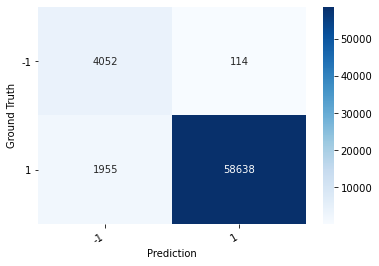

In [25]:
show_metrics(y_test, y_test_pred)


Resulting Metrics
Accuracy : 0.9649
AUC : 0.979951
F1 Score : 0.980869

              precision    recall  f1-score   support

          -1       0.65      1.00      0.79      2922
           1       1.00      0.96      0.98     41836

    accuracy                           0.96     44758
   macro avg       0.83      0.98      0.88     44758
weighted avg       0.98      0.96      0.97     44758




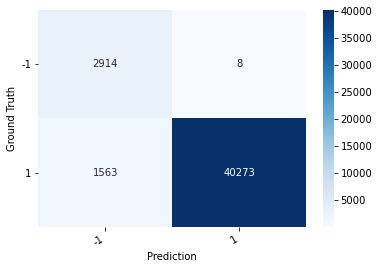

In [27]:
show_metrics(y_test_v2, y_test_v2_pred)

# Local Outlier Factor

In [30]:
from sklearn.neighbors import LocalOutlierFactor

In [31]:
clfLOF = LocalOutlierFactor(
    n_neighbors=7,
    metric='manhattan',
    algorithm='auto',
    contamination=0.05,
    n_jobs=-1,
)

In [32]:
clfLOF.fit(x_train, y_train)

LocalOutlierFactor(contamination=0.05, metric='manhattan', n_jobs=-1,
                   n_neighbors=7)

In [33]:
y_validation_pred = clfLOF.fit_predict(x_validation)
y_test_pred = clfLOF.fit_predict(x_test)
y_test_v2_pred = clfLOF.fit_predict(x_test_v2)


Resulting Metrics
Accuracy : 0.8989
AUC : 0.520915
F1 Score : 0.946446

              precision    recall  f1-score   support

          -1       0.11      0.09      0.10      1244
           1       0.94      0.95      0.95     18756

    accuracy                           0.90     20000
   macro avg       0.53      0.52      0.52     20000
weighted avg       0.89      0.90      0.89     20000




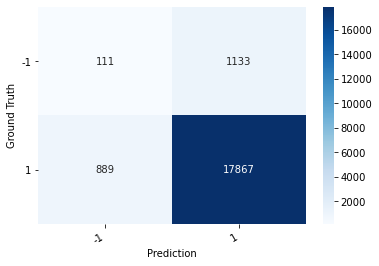

In [34]:
show_metrics(y_validation, y_validation_pred)


Resulting Metrics
Accuracy : 0.9012
AUC : 0.537801
F1 Score : 0.947606

              precision    recall  f1-score   support

          -1       0.16      0.12      0.14      4166
           1       0.94      0.95      0.95     60593

    accuracy                           0.90     64759
   macro avg       0.55      0.54      0.54     64759
weighted avg       0.89      0.90      0.90     64759




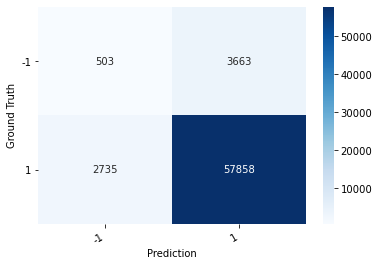

In [35]:
show_metrics(y_test, y_test_pred)


Resulting Metrics
Accuracy : 0.9022
AUC : 0.545015
F1 Score : 0.948125

              precision    recall  f1-score   support

          -1       0.18      0.13      0.15      2922
           1       0.94      0.96      0.95     41836

    accuracy                           0.90     44758
   macro avg       0.56      0.55      0.55     44758
weighted avg       0.89      0.90      0.90     44758




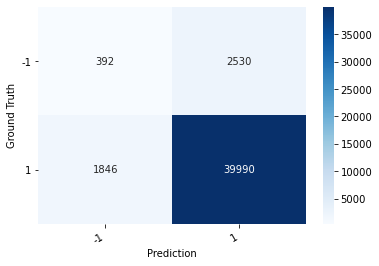

In [36]:
show_metrics(y_test_v2, y_test_v2_pred)

## Catboost

In [37]:
from catboost import CatBoostClassifier

In [40]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.02,
    depth=12,
    eval_metric='AUC',
    random_seed = SEED,
    bagging_temperature = 0.2,  # This parameter is responsible for Bayesian bootstrap. By changing this parameter from 0 to +infty you can controll intensity of the bootstrap
    od_type='Iter',
    od_wait=100,    # instead of these 2, we can set early_stopping_rounds
    task_type="GPU",
    verbose=True
)

In [41]:
model.fit(x_train,y_train,eval_set=(x_validation,y_validation))

0:	learn: 0.9995805	test: 0.7440927	best: 0.7440927 (0)	total: 103ms	remaining: 20.5s
1:	learn: 0.9995735	test: 0.9422297	best: 0.9422297 (1)	total: 112ms	remaining: 11.1s
2:	learn: 0.9992452	test: 0.9624948	best: 0.9624948 (2)	total: 125ms	remaining: 8.23s
3:	learn: 0.9992072	test: 0.9596758	best: 0.9624948 (2)	total: 140ms	remaining: 6.87s
4:	learn: 0.9992828	test: 0.9705183	best: 0.9705183 (4)	total: 149ms	remaining: 5.81s
5:	learn: 0.9996566	test: 0.9679819	best: 0.9705183 (4)	total: 212ms	remaining: 6.84s
6:	learn: 0.9997667	test: 0.9673088	best: 0.9705183 (4)	total: 276ms	remaining: 7.61s
7:	learn: 0.9997515	test: 0.9650552	best: 0.9705183 (4)	total: 336ms	remaining: 8.06s
8:	learn: 0.9997838	test: 0.9708472	best: 0.9708472 (8)	total: 391ms	remaining: 8.3s
9:	learn: 0.9998118	test: 0.9766127	best: 0.9766127 (9)	total: 443ms	remaining: 8.42s
10:	learn: 0.9998221	test: 0.9709592	best: 0.9766127 (9)	total: 496ms	remaining: 8.52s
11:	learn: 0.9998367	test: 0.9696014	best: 0.9766127 (

In [42]:
y_validation_pred = model.predict(x_validation)
y_test_pred = model.predict(x_test)
y_test_v2_pred = model.predict(x_test_v2)


Resulting Metrics
Accuracy : 0.9662
AUC : 0.848758
F1 Score : 0.981995

              precision    recall  f1-score   support

          -1       0.73      0.71      0.72      1244
           1       0.98      0.98      0.98     18756

    accuracy                           0.97     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.97      0.97      0.97     20000




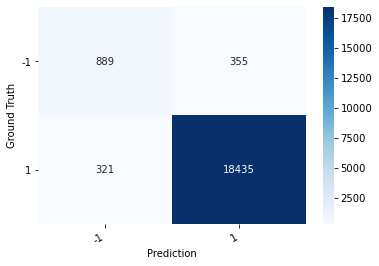

In [43]:
show_metrics(y_validation, y_validation_pred)


Resulting Metrics
Accuracy : 0.9757
AUC : 0.926984
F1 Score : 0.986949

              precision    recall  f1-score   support

          -1       0.78      0.87      0.82      4166
           1       0.99      0.98      0.99     60593

    accuracy                           0.98     64759
   macro avg       0.88      0.93      0.90     64759
weighted avg       0.98      0.98      0.98     64759




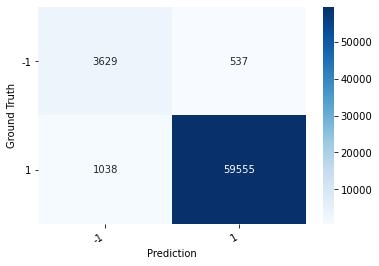

In [44]:
show_metrics(y_test, y_test_pred)


Resulting Metrics
Accuracy : 0.9799
AUC : 0.960288
F1 Score : 0.989187

              precision    recall  f1-score   support

          -1       0.79      0.94      0.86      2922
           1       1.00      0.98      0.99     41836

    accuracy                           0.98     44758
   macro avg       0.89      0.96      0.92     44758
weighted avg       0.98      0.98      0.98     44758




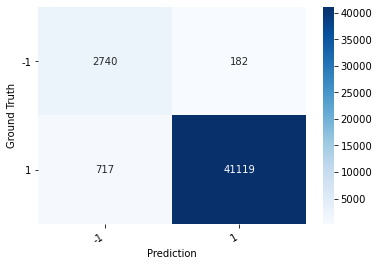

In [45]:
show_metrics(y_test_v2, y_test_v2_pred)

In [ ]:
# classify anomalies and normals
# train set: kdd_train_probe
# validation set (for hyperparam tuning): kdd_valid_probe
# test set: kdd_test_v2_probe

# Report your auc roc score and avg. macro f1 score on test set
# macro f1 score